<a href="https://colab.research.google.com/github/Devika532/elevator-behaviour-classification/blob/main/Machinelearningelevator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install numpy pandas scikit-learn matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import os, datetime

plt.rcParams['figure.dpi'] = 140
np.random.seed(42)

print("Imports OK ✅")


Imports OK ✅


In [ ]:
SAVE_TO_DRIVE = False  # set True if you want to save to Google Drive

if SAVE_TO_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    FOLDER = "/content/drive/MyDrive/elevator_project"
else:
    FOLDER = "/content/elevator_project"

os.makedirs(FOLDER, exist_ok=True)
print("Saving to:", FOLDER)


Saving to: /content/elevator_project


In [ ]:
FLOORS = ['B','G'] + [str(i) for i in range(1,13)]
N_FLOORS = len(FLOORS)

CLASSES = ['Student','Faculty','Cleaner','Visitor','Contractor']

SIZE_MAP = {
    'Student': 700,
    'Faculty': 500,
    'Cleaner': 350,
    'Visitor': 550,
    'Contractor': 200
}

print("Floors:", FLOORS)
print("Total rows:", sum(SIZE_MAP.values()))


Floors: ['B', 'G', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
Total rows: 2300


In [ ]:
def sample_time():
    peaks = np.array([9,13,17])
    base = np.random.normal(np.random.choice(peaks), 2.5)
    hour = int(np.clip(round(base), 0, 23))

    is_weekend = np.random.rand() < 0.20
    if is_weekend:
        hour = int(np.clip(np.random.normal(14, 4), 0, 23))
    return hour, is_weekend


def floors_to_vector(selected):
    vec = np.zeros(N_FLOORS, dtype=int)
    for f in selected:
        vec[FLOORS.index(f)] = 1
    return vec


def consecutive_run_length(selected):
    idxs = [FLOORS.index(f) for f in selected]
    if not idxs:
        return 0
    best = run = 1
    for i in range(1, len(idxs)):
        if idxs[i] == idxs[i-1] + 1:
            run += 1
            best = max(best, run)
        else:
            run = 1
    return best


In [ ]:
def add_noise(selected, prob_extra=0.03, prob_drop=0.02):
    # accidental extra press
    if np.random.rand() < prob_extra:
        cand = [f for f in FLOORS if f not in selected]
        if cand:
            selected.append(np.random.choice(cand))

    # accidental drop
    if np.random.rand() < prob_drop and len(selected) > 1:
        selected.pop(np.random.randint(len(selected)))

    selected = list(sorted(set(selected), key=lambda x: FLOORS.index(x)))
    return selected


In [ ]:
def simulate_trip(user_type):
    hour, is_weekend = sample_time()

    # ---------- STUDENTS (1–6 strongly) ----------
    if user_type == 'Student':
        n_press = np.random.choice([1,2], p=[0.6,0.4])
        selected = list(np.random.choice(['1','2','3','4','5','6'], size=n_press, replace=False))
        if np.random.rand() < 0.15:
            selected.append('G')

    # ---------- FACULTY (4–10 strongly) ----------
    elif user_type == 'Faculty':
        n_press = np.random.choice([1,2], p=[0.55,0.45])
        selected = list(np.random.choice(['4','5','6','7','8','9','10'], size=n_press, replace=False))
        if np.random.rand() < 0.35:
            selected.append('G')

    # ---------- CLEANERS (long runs, distinct) ----------
    elif user_type == 'Cleaner':
        start = np.random.choice(['B','G','1'])
        seq_len = np.random.choice([4,5,6,7,8], p=[0.1,0.2,0.3,0.25,0.15])
        sidx = FLOORS.index(start)
        selected = FLOORS[sidx:min(sidx + seq_len, N_FLOORS-1) + 1]
        if np.random.rand() < 0.10 and len(selected) > 3:
            skip = np.random.choice(selected[1:-1])
            selected = [f for f in selected if f != skip]

    # ---------- VISITORS (G + 1 random floor) ----------
    elif user_type == 'Visitor':
        selected = ['G']
        selected.append(str(np.random.choice(range(1,13))))

    # ---------- CONTRACTORS (B + technical floors) ----------
    elif user_type == 'Contractor':
        selected = []
        if np.random.rand() < 0.8:
            selected.append('B')
        tech = np.random.choice(['5','7','9','11'], size=np.random.choice([1,2]), replace=False)
        selected += list(tech)
        if np.random.rand() < 0.4:
            selected.append('G')

    # Add noise LAST
    selected = add_noise(selected)

    vec = floors_to_vector(selected)
    idxs = [FLOORS.index(f) for f in selected]

    return {
        **{f'press_{f}': vec[i] for i,f in enumerate(FLOORS)},
        'n_pressed': len(selected),
        'has_basement': int('B' in selected),
        'has_ground': int('G' in selected),
        'max_consecutive_run': consecutive_run_length(selected),
        'floor_span': (max(idxs) - min(idxs)) if idxs else 0,
        'hour': hour,
        'hour_sin': np.sin(2*np.pi*hour/24),
        'hour_cos': np.cos(2*np.pi*hour/24),
        'is_weekend': int(is_weekend),
        'label': user_type
    }


In [ ]:
rows = []
for cls in CLASSES:
    for _ in range(SIZE_MAP[cls]):
        rows.append(simulate_trip(cls))

df = pd.DataFrame(rows)
print(df.shape)
df.head()


(2300, 24)


,press_B,press_G,press_1,press_2,press_3,press_4,press_5,press_6,press_7,press_8,...,n_pressed,has_basement,has_ground,max_consecutive_run,floor_span,hour,hour_sin,hour_cos,is_weekend,label
0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,16,-0.866025,-0.500000,0,Student
1,0,1,0,0,0,0,0,1,0,0,...,3,0,1,1,11,14,-0.500000,-0.866025,1,Student
2,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,14,-0.500000,-0.866025,1,Student
3,0,0,0,0,1,1,0,0,0,0,...,2,0,0,2,1,7,0.965926,-0.258819,0,Student
4,0,0,1,0,1,0,0,0,0,0,...,2,0,0,1,2,9,0.707107,-0.707107,1,Student


In [ ]:
csv_path = os.path.join(FOLDER, "elevator_dataset_v2.csv")
df.to_csv(csv_path, index=False)
csv_path


'/content/elevator_project/elevator_dataset_v2.csv'

In [ ]:
X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

binary_cols = [c for c in X.columns if c.startswith('press_')] + ['has_basement','has_ground','is_weekend']
numeric_cols = [c for c in X.columns if c not in binary_cols]

preproc = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols)
], remainder='passthrough')

len(binary_cols), len(numeric_cols)


(17, 6)

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

pipelines = {
    'LogReg': Pipeline([('pre', preproc),
                        ('clf', LogisticRegression(max_iter=2000, multi_class='ovr', random_state=42))]),

    'SVM_RBF': Pipeline([('pre', preproc),
                        ('clf', SVC())]),

    'RandForest': Pipeline([('pre', preproc),
                        ('clf', RandomForestClassifier(random_state=42))])
}

param_grids = {
    'LogReg':   {'clf__C': [0.5, 1, 3]},
    'SVM_RBF':  {'clf__kernel': ['rbf'], 'clf__C': [1, 3], 'clf__gamma': ['scale', 0.05]},
    'RandForest': {'clf__n_estimators': [200], 'clf__max_depth': [None, 12], 'clf__min_samples_leaf': [1,2]}
}

results = []
best_models = {}

for name in ['LogReg','SVM_RBF','RandForest']:
    print(f"\nTUNING {name}...")
    grid = GridSearchCV(pipelines[name], param_grids[name],
                        scoring='f1_macro', cv=cv, n_jobs=-1, refit=True)

    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average='macro')

    results.append([name, grid.best_params_, grid.best_score_, acc, f1m])
    print("Best params:", grid.best_params_)
    print("Accuracy:", acc, " Macro F1:", f1m)

results_df = pd.DataFrame(results, columns=['Model','Best Params','CV F1','Test Acc','Test F1'])
results_df



TUNING LogReg...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best params: {'clf__C': 3}
Accuracy: 0.8608695652173913  Macro F1: 0.8694939759036144

TUNING SVM_RBF...
Best params: {'clf__C': 3, 'clf__gamma': 0.05, 'clf__kernel': 'rbf'}
Accuracy: 0.8652173913043478  Macro F1: 0.8716314668040928

TUNING RandForest...
Best params: {'clf__max_depth': 12, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 200}
Accuracy: 0.8630434782608696  Macro F1: 0.8692881790544884


,Model,Best Params,CV F1,Test Acc,Test F1
0,LogReg,{'clf__C': 3},0.876181,0.860870,0.869494
1,SVM_RBF,"{'clf__C': 3, 'clf__gamma': 0.05, 'clf__kernel...",0.876310,0.865217,0.871631
2,RandForest,"{'clf__max_depth': 12, 'clf__min_samples_leaf'...",0.865989,0.863043,0.869288


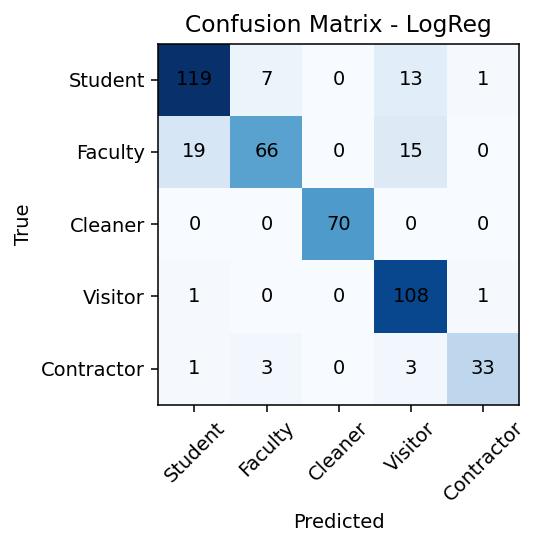

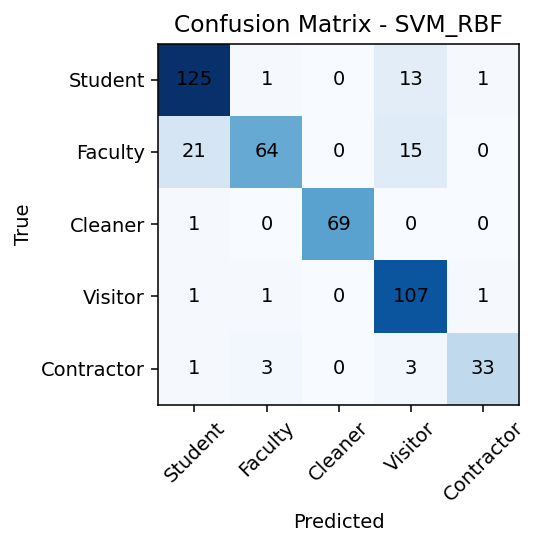

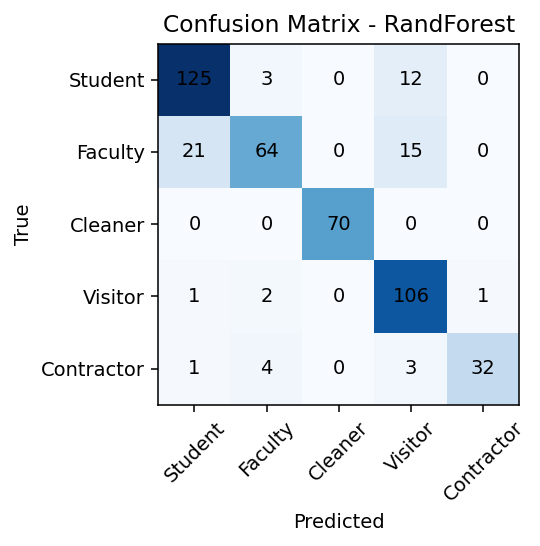

In [ ]:
def plot_cm(cm, labels, title, path):
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap='Blues')
    plt.title(title)
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.yticks(range(len(labels)), labels)
    for (i,j),val in np.ndenumerate(cm):
        plt.text(j, i, val, ha='center', va='center')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.show()

for name, model in best_models.items():
    cm = confusion_matrix(y_test, model.predict(X_test), labels=CLASSES)
    save_path = os.path.join(FOLDER, f"cm_{name}.png")
    plot_cm(cm, CLASSES, f"Confusion Matrix - {name}", save_path)


In [ ]:
rf = best_models['RandForest'].named_steps['clf']

feat_names = numeric_cols + binary_cols
importances = rf.feature_importances_
imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
imp_df = imp_df.sort_values('importance', ascending=False)

imp_df.head(10)


,feature,importance
0,n_pressed,0.147887
1,max_consecutive_run,0.099255
21,has_ground,0.091409
2,floor_span,0.088546
7,press_G,0.071984
20,has_basement,0.060475
8,press_1,0.053417
10,press_3,0.050804
6,press_B,0.044739
9,press_2,0.042653


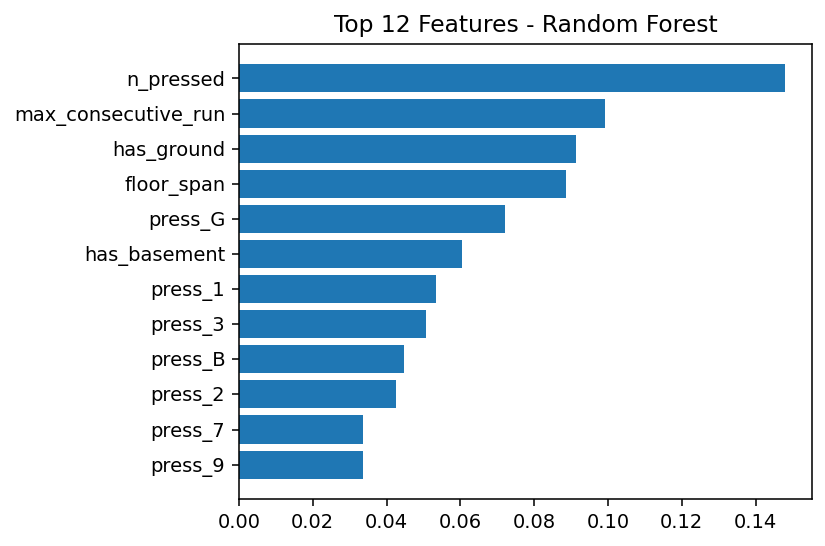

In [ ]:
top = imp_df.head(12)
plt.figure(figsize=(6,4))
plt.barh(top['feature'][::-1], top['importance'][::-1])
plt.title("Top 12 Features - Random Forest")
plt.tight_layout()
save_path = os.path.join(FOLDER, "feature_importance_top12.png")
plt.savefig(save_path, dpi=150)
plt.show()


In [ ]:
for name, model in best_models.items():
    print("\n====", name, "====")
    print(classification_report(y_test, model.predict(X_test), digits=4))



==== LogReg ====
              precision    recall  f1-score   support

     Cleaner     1.0000    1.0000    1.0000        70
  Contractor     0.9429    0.8250    0.8800        40
     Faculty     0.8684    0.6600    0.7500       100
     Student     0.8500    0.8500    0.8500       140
     Visitor     0.7770    0.9818    0.8675       110

    accuracy                         0.8609       460
   macro avg     0.8877    0.8634    0.8695       460
weighted avg     0.8674    0.8609    0.8579       460


==== SVM_RBF ====
              precision    recall  f1-score   support

     Cleaner     1.0000    0.9857    0.9928        70
  Contractor     0.9429    0.8250    0.8800        40
     Faculty     0.9275    0.6400    0.7574       100
     Student     0.8389    0.8929    0.8651       140
     Visitor     0.7754    0.9727    0.8629       110

    accuracy                         0.8652       460
   macro avg     0.8969    0.8633    0.8716       460
weighted avg     0.8765    0.8652    0.8

In [ ]:
def demo_predict():
    row = simulate_trip(np.random.choice(CLASSES))
    df_demo = pd.DataFrame([row])
    pred = best_models['RandForest'].predict(df_demo.drop(columns=['label']))[0]
    return row['label'], pred, df_demo

demo_predict()


(np.str_('Contractor'),
 'Visitor',
    press_B  press_G  press_1  press_2  press_3  press_4  press_5  press_6  \
 0        0        1        0        0        0        0        1        0   
 
    press_7  press_8  ...  n_pressed  has_basement  has_ground  \
 0        0        0  ...          2             0           1   
 
    max_consecutive_run  floor_span  hour  hour_sin  hour_cos  is_weekend  \
 0                    1           5    14      -0.5 -0.866025           0   
 
         label  
 0  Contractor  
 
 [1 rows x 24 columns])